### Necessary imports

In [1]:
import os
import umap
import itertools
import smart_open
import numpy as np
import pandas as pd
import pickle as pkl
import os.path as op
from Bio import SeqIO
from Bio import pairwise2
from textwrap import wrap
from itertools import groupby
import matplotlib.pyplot as plt
from rgramlib.rgramlib import *
from scipy.stats import spearmanr
from gensim.models import FastText
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from scipy.spatial.distance import cosine

### Rgram instance definition

In [2]:
rgram = RGramMaker(min_num=1, alphabet="ATGC")

In [3]:
with open("rgram_hg38.pkl", "rb") as ih:
    rgram = pkl.load(ih)

AttributeError: Can't get attribute 'RGramMaker' on <module 'rgramlib' (namespace)>

### Rgram training

In [4]:
HG38PATH = "/home/bakirillov/HDD/data/genomes/HumanHG38_dna2vec/chroms/"

In [5]:
def chunk(in_string,num_chunks):
    chunk_size = len(in_string)//num_chunks
    if len(in_string) % num_chunks: 
        chunk_size += 1
    iterator = iter(in_string)
    for _ in range(num_chunks):
        accumulator = list()
        for _ in range(chunk_size):
            try: accumulator.append(next(iterator))
            except StopIteration: break
        yield(''.join(accumulator))

In [6]:
filenames = np.random.permutation(
    list(filter(lambda x: len(x) < 9 and "M" not in x, [b for b in os.walk(HG38PATH)][0][2]))
)

In [7]:
def train_rgram(filenames, match=None):
    rgram = RGramMaker(min_num=1, alphabet="ATGC")
    error_chunks = []
    break_all = False
    for i,a in enumerate(filenames):
        print(i,a)
        #print(list(set(str([l for l in SeqIO.parse(op.join(HG38PATH, a), "fasta")][0].seq).upper())))
        current_chr = list(
            filter(
                lambda x: len(x) != 0,
                str([l for l in SeqIO.parse(op.join(HG38PATH, a), "fasta")][0].seq).upper().split("N")
            )
        )
        total_segments = len(current_chr)
        for cnt, non_overlapping in enumerate(current_chr):
            if len(non_overlapping) < 10000:
                chunk_size = len(non_overlapping)
            else:
                chunk_size = 10000
            num_chunks = int(len(non_overlapping)/chunk_size)
            print("Segment #"+str(cnt)+" of "+str(total_segments)+": "+str(num_chunks))
            for w in tqdm(chunk(non_overlapping, num_chunks)):
                try:
                    rgram.compress(w)
                except Exception as e:
                    print("Chunk raised an exception", e)
                    error_chunks.append((i, a, w))
                if match:
                    known = len(match.B.keys())
                    if len(rgram.B.keys()) == len(match.B.keys()):
                        print("All r-grams are constructed")
                        break_all = True
                        break
            if break_all:
                break
        if break_all:
            break
    return(rgram, error_chunks)

In [8]:
HG38PATH

'/home/bakirillov/HDD/data/genomes/HumanHG38_dna2vec/chroms/'

In [9]:
final_rg, errors = train_rgram(
    filenames, 
    rgram
)

0 chr12.fa


0it [00:00, ?it/s]

Segment #0 of 29: 679


679it [00:19, 34.94it/s]
1it [00:00, 1846.90it/s]
2it [00:00, 15.02it/s]

Segment #1 of 29: 1
Segment #2 of 29: 28


28it [00:01, 25.37it/s]
4it [00:00, 31.44it/s]

Segment #3 of 29: 2763


2763it [01:05, 41.96it/s]
2it [00:00, 30.95it/s]
1it [00:00, 20.99it/s]
1it [00:00, 120.29it/s]
1it [00:00, 207.55it/s]
1it [00:00, 134.27it/s]
1it [00:00, 131.10it/s]
1it [00:00, 26.24it/s]
0it [00:00, ?it/s]

Segment #4 of 29: 2
Segment #5 of 29: 1
Segment #6 of 29: 1
Segment #7 of 29: 1
Segment #8 of 29: 1
Segment #9 of 29: 1
Segment #10 of 29: 1
Segment #11 of 29: 182


182it [00:03, 46.04it/s]
5it [00:00, 43.37it/s]

Segment #12 of 29: 10


10it [00:00, 43.06it/s]
1it [00:00, 23.88it/s]
5it [00:00, 41.36it/s]

Segment #13 of 29: 1
Segment #14 of 29: 16


16it [00:00, 42.37it/s]
5it [00:00, 43.53it/s]

Segment #15 of 29: 21


21it [00:00, 43.78it/s]
1it [00:00, 76.01it/s]
1it [00:00, 46.85it/s]
7it [00:00, 42.91it/s]

Segment #16 of 29: 1
Segment #17 of 29: 1
Segment #18 of 29: 7



1it [00:00, 262.14it/s]
4it [00:00, 38.90it/s]
0it [00:00, ?it/s]

Segment #19 of 29: 1
Segment #20 of 29: 4
Segment #21 of 29: 7


7it [00:00, 36.87it/s]
5it [00:00, 43.97it/s]

Segment #22 of 29: 8463


8463it [03:32, 39.74it/s]
5it [00:00, 48.51it/s]

Segment #23 of 29: 135


135it [00:04, 30.16it/s]
3it [00:00, 41.79it/s]
3it [00:00, 25.72it/s]

Segment #24 of 29: 3
Segment #25 of 29: 874


874it [00:23, 37.12it/s]
1it [00:00, 865.16it/s]
1it [00:00, 1065.90it/s]
2it [00:00, 15.57it/s]

Segment #26 of 29: 1
Segment #27 of 29: 1
Segment #28 of 29: 104


104it [00:04, 31.22it/s]


1 chr19.fa


4it [00:00, 36.20it/s]

Segment #0 of 8: 2438


2438it [01:35, 25.46it/s]
5it [00:00, 43.16it/s]
0it [00:00, ?it/s]

Segment #1 of 8: 5
Segment #2 of 8: 33


33it [00:00, 44.11it/s]
1it [00:00, 99.28it/s]
1it [00:00, 158.89it/s]
1it [00:00, 104.67it/s]
5it [00:00, 46.16it/s]

Segment #3 of 8: 1
Segment #4 of 8: 1
Segment #5 of 8: 1
Segment #6 of 8: 228


228it [00:04, 46.07it/s]
5it [00:00, 46.48it/s]

Segment #7 of 8: 3136


3136it [01:41, 30.95it/s]


2 chr22.fa


4it [00:00, 38.14it/s]

Segment #0 of 48: 27


27it [00:00, 41.69it/s]
3it [00:00, 20.55it/s]
0it [00:00, ?it/s]

Segment #1 of 48: 3
Segment #2 of 48: 4


4it [00:00, 42.43it/s]
3it [00:00, 24.72it/s]

Segment #3 of 48: 5


5it [00:00, 22.60it/s]
4it [00:00, 37.79it/s]
0it [00:00, ?it/s]

Segment #4 of 48: 4
Segment #5 of 48: 16


16it [00:00, 39.78it/s]
6it [00:00, 42.95it/s]
0it [00:00, ?it/s]

Segment #6 of 48: 6
Segment #7 of 48: 8


8it [00:00, 30.08it/s]
4it [00:00, 29.88it/s]
0it [00:00, ?it/s]

Segment #8 of 48: 4
Segment #9 of 48: 20


20it [00:00, 36.60it/s]
4it [00:00, 39.64it/s]

Segment #10 of 48: 19


19it [00:00, 35.93it/s]
5it [00:00, 47.75it/s]

Segment #11 of 48: 16


16it [00:00, 45.35it/s]
5it [00:00, 40.28it/s]

Segment #12 of 48: 15


15it [00:00, 36.79it/s]
3it [00:00, 36.17it/s]
4it [00:00, 50.31it/s]
0it [00:00, ?it/s]

Segment #13 of 48: 3
Segment #14 of 48: 4
Segment #15 of 48: 3


3it [00:00, 33.71it/s]
2it [00:00, 41.02it/s]
1it [00:00, 131.12it/s]
1it [00:00, 25.94it/s]
1it [00:00, 62.68it/s]
0it [00:00, ?it/s]

Segment #16 of 48: 2
Segment #17 of 48: 1
Segment #18 of 48: 1
Segment #19 of 48: 1
Segment #20 of 48: 8


8it [00:00, 42.01it/s]
5it [00:00, 42.61it/s]
0it [00:00, ?it/s]

Segment #21 of 48: 5
Segment #22 of 48: 6


6it [00:00, 40.05it/s]
2it [00:00, 39.07it/s]
1it [00:00, 56.35it/s]
1it [00:00, 134.68it/s]
2it [00:00, 39.38it/s]
1it [00:00, 100.80it/s]
0it [00:00, ?it/s]

Segment #23 of 48: 2
Segment #24 of 48: 1
Segment #25 of 48: 1
Segment #26 of 48: 2
Segment #27 of 48: 1
Segment #28 of 48: 113


113it [00:02, 45.25it/s]
1it [00:00, 1417.95it/s]
1it [00:00, 1065.36it/s]
1it [00:00, 362.95it/s]
5it [00:00, 46.07it/s]

Segment #29 of 48: 1
Segment #30 of 48: 1
Segment #31 of 48: 1
Segment #32 of 48: 63


63it [00:01, 44.35it/s]
5it [00:00, 44.41it/s]

Segment #33 of 48: 112


112it [00:02, 45.40it/s]
1it [00:00, 264.47it/s]
1it [00:00, 215.70it/s]
1it [00:00, 112.60it/s]
1it [00:00, 316.15it/s]
1it [00:00, 93.49it/s]
1it [00:00, 46.25it/s]
1it [00:00, 58.05it/s]
1it [00:00, 122.71it/s]
1it [00:00, 1416.04it/s]
0it [00:00, ?it/s]

Segment #34 of 48: 1
Segment #35 of 48: 1
Segment #36 of 48: 1
Segment #37 of 48: 1
Segment #38 of 48: 1
Segment #39 of 48: 1
Segment #40 of 48: 1
Segment #41 of 48: 1
Segment #42 of 48: 1
Segment #43 of 48: 191


191it [00:05, 34.51it/s]
3it [00:00, 29.57it/s]

Segment #44 of 48: 9


9it [00:00, 36.69it/s]
4it [00:00, 24.48it/s]

Segment #45 of 48: 17


17it [00:00, 19.37it/s]
5it [00:00, 47.20it/s]

Segment #46 of 48: 3126


3126it [01:48, 28.85it/s]
4it [00:00, 26.62it/s]

Segment #47 of 48: 83


83it [00:03, 21.44it/s]


3 chr4.fa


5it [00:00, 45.47it/s]

Segment #0 of 17: 141


141it [00:04, 28.58it/s]
1it [00:00, 323.43it/s]
3it [00:00, 28.09it/s]

Segment #1 of 17: 1
Segment #2 of 17: 735


735it [00:26, 18.86it/s]
2it [00:00, 19.32it/s]

Segment #3 of 17: 45


45it [00:01, 31.33it/s]
3it [00:00, 24.78it/s]

Segment #4 of 17: 2249


2249it [00:51, 43.61it/s]
1it [00:00, 139.38it/s]
5it [00:00, 44.00it/s]

Segment #5 of 17: 1
Segment #6 of 17: 99


99it [00:02, 43.20it/s]
5it [00:00, 44.26it/s]

Segment #7 of 17: 1649


1649it [00:38, 42.56it/s]
3it [00:00, 29.40it/s]

Segment #8 of 17: 17


17it [00:00, 46.02it/s]
1it [00:00, 271.55it/s]
5it [00:00, 46.26it/s]

Segment #9 of 17: 1
Segment #10 of 17: 76


76it [00:01, 46.19it/s]
5it [00:00, 46.45it/s]

Segment #11 of 17: 63


63it [00:01, 46.36it/s]
5it [00:00, 44.85it/s]

Segment #12 of 17: 31


31it [00:00, 45.71it/s]
5it [00:00, 45.63it/s]

Segment #13 of 17: 32


32it [00:00, 45.69it/s]
5it [00:00, 41.64it/s]

Segment #14 of 17: 708


708it [00:16, 43.40it/s]
4it [00:00, 36.78it/s]

Segment #15 of 17: 13120


13120it [04:59, 43.81it/s]
3it [00:00, 54.98it/s]


Chunk raised an exception list index out of range
Segment #16 of 17: 3
4 chr21.fa


2it [00:00, 11.80it/s]

Segment #0 of 51: 15


15it [00:00, 16.45it/s]
5it [00:00, 47.16it/s]

Segment #1 of 51: 17


17it [00:00, 45.68it/s]
1it [00:00, 82.37it/s]
5it [00:00, 45.07it/s]

Segment #2 of 51: 1
Segment #3 of 51: 12


12it [00:00, 43.74it/s]
5it [00:00, 43.40it/s]

Segment #4 of 51: 11


11it [00:00, 37.80it/s]
7it [00:00, 37.38it/s]
0it [00:00, ?it/s]

Segment #5 of 51: 7
Segment #6 of 51: 19


19it [00:00, 32.12it/s]
6it [00:00, 49.05it/s]

Segment #7 of 51: 16


16it [00:00, 47.67it/s]
4it [00:00, 26.54it/s]

Segment #8 of 51: 15


15it [00:00, 30.60it/s]
5it [00:00, 42.63it/s]

Segment #9 of 51: 10


10it [00:00, 43.23it/s]
5it [00:00, 47.04it/s]

Segment #10 of 51: 14


14it [00:00, 43.16it/s]
5it [00:00, 44.14it/s]

Segment #11 of 51: 16


16it [00:00, 39.61it/s]
5it [00:00, 43.99it/s]

Segment #12 of 51: 12


12it [00:00, 44.56it/s]
5it [00:00, 47.94it/s]

Segment #13 of 51: 12


12it [00:00, 43.88it/s]
4it [00:00, 38.89it/s]

Segment #14 of 51: 14


14it [00:00, 42.83it/s]
4it [00:00, 37.15it/s]

Segment #15 of 51: 12


12it [00:00, 41.51it/s]
4it [00:00, 37.15it/s]

Segment #16 of 51: 13


13it [00:00, 42.02it/s]
5it [00:00, 42.64it/s]

Segment #17 of 51: 11


11it [00:00, 35.99it/s]
4it [00:00, 32.07it/s]
0it [00:00, ?it/s]

Segment #18 of 51: 4
Segment #19 of 51: 16


16it [00:00, 32.01it/s]
4it [00:00, 39.93it/s]

Segment #20 of 51: 18


18it [00:00, 41.53it/s]
4it [00:00, 36.47it/s]

Segment #21 of 51: 12


12it [00:00, 35.24it/s]
3it [00:00, 24.16it/s]

Segment #22 of 51: 20


20it [00:00, 36.62it/s]
5it [00:00, 46.24it/s]

Segment #23 of 51: 13


13it [00:00, 48.05it/s]
6it [00:00, 51.35it/s]

Segment #24 of 51: 64


64it [00:01, 39.42it/s]
1it [00:00, 40.40it/s]
4it [00:00, 38.54it/s]

Segment #25 of 51: 1
Segment #26 of 51: 49


49it [00:01, 43.81it/s]
2it [00:00, 39.84it/s]
5it [00:00, 42.29it/s]

Segment #27 of 51: 2
Segment #28 of 51: 8


8it [00:00, 42.05it/s]
5it [00:00, 42.77it/s]
0it [00:00, ?it/s]

Segment #29 of 51: 5
Segment #30 of 51: 6


6it [00:00, 43.73it/s]
2it [00:00, 44.42it/s]
1it [00:00, 67.96it/s]
1it [00:00, 135.04it/s]
2it [00:00, 41.11it/s]
0it [00:00, ?it/s]

Segment #31 of 51: 2
Segment #32 of 51: 1
Segment #33 of 51: 1
Segment #34 of 51: 2
Segment #35 of 51: 113


113it [00:02, 45.90it/s]
1it [00:00, 1206.99it/s]
1it [00:00, 956.73it/s]
1it [00:00, 324.11it/s]
5it [00:00, 45.31it/s]

Segment #36 of 51: 1
Segment #37 of 51: 1
Segment #38 of 51: 1
Segment #39 of 51: 63


63it [00:01, 46.04it/s]
5it [00:00, 46.53it/s]

Segment #40 of 51: 1881


1881it [00:43, 36.94it/s]
1it [00:00, 1718.27it/s]
5it [00:00, 48.53it/s]

Segment #41 of 51: 1
Segment #42 of 51: 712


712it [00:17, 35.43it/s]
3it [00:00, 26.62it/s]

Segment #43 of 51: 267


267it [00:06, 40.82it/s]
3it [00:00, 22.49it/s]

Segment #44 of 51: 24


24it [00:00, 25.45it/s]
1it [00:00, 542.25it/s]
1it [00:00, 1069.70it/s]
3it [00:00, 20.38it/s]

Segment #45 of 51: 1
Segment #46 of 51: 1
Segment #47 of 51: 78


78it [00:02, 28.98it/s]
4it [00:00, 23.99it/s]

Segment #48 of 51: 59


59it [00:01, 30.95it/s]
2it [00:00, 15.69it/s]

Segment #49 of 51: 20


20it [00:01, 18.56it/s]
2it [00:00, 15.94it/s]

Segment #50 of 51: 323


323it [00:11, 27.68it/s]


5 chr3.fa


5it [00:00, 43.76it/s]

Segment #0 of 28: 1680


1680it [00:43, 38.82it/s]
1it [00:00, 181.62it/s]
7it [00:00, 38.05it/s]
1it [00:00, 53.33it/s]

Segment #1 of 28: 1
Segment #2 of 28: 7
Segment #3 of 28: 1



5it [00:00, 45.80it/s]

Segment #4 of 28: 4321


4321it [01:50, 39.17it/s]
4it [00:00, 38.47it/s]

Segment #5 of 28: 8


8it [00:00, 37.97it/s]
3it [00:00, 29.84it/s]

Segment #6 of 28: 598


598it [00:14, 42.24it/s]
1it [00:00, 60.22it/s]
5it [00:00, 42.54it/s]

Segment #7 of 28: 1
Segment #8 of 28: 2435


2435it [00:56, 43.43it/s]
1it [00:00, 918.59it/s]
1it [00:00, 30.09it/s]
5it [00:00, 41.82it/s]

Segment #9 of 28: 1
Segment #10 of 28: 1
Segment #11 of 28: 13


13it [00:00, 40.36it/s]
2it [00:00, 40.44it/s]
5it [00:00, 46.99it/s]

Segment #12 of 28: 2
Segment #13 of 28: 46


46it [00:00, 46.54it/s]
1it [00:00, 33.24it/s]
1it [00:00, 203.52it/s]
1it [00:00, 237.19it/s]
1it [00:00, 88.24it/s]
1it [00:00, 69.59it/s]
1it [00:00, 55.17it/s]
4it [00:00, 38.19it/s]

Segment #14 of 28: 1
Segment #15 of 28: 1
Segment #16 of 28: 1
Segment #17 of 28: 1
Segment #18 of 28: 1
Segment #19 of 28: 1
Segment #20 of 28: 5


5it [00:00, 40.98it/s]
1it [00:00, 23.33it/s]
5it [00:00, 35.59it/s]

Segment #21 of 28: 1
Segment #22 of 28: 7


7it [00:00, 32.33it/s]
4it [00:00, 38.50it/s]

Segment #23 of 28: 11


11it [00:00, 39.89it/s]
5it [00:00, 45.58it/s]

Segment #24 of 28: 33


33it [00:00, 45.74it/s]
5it [00:00, 46.44it/s]

Segment #25 of 28: 157


157it [00:03, 46.59it/s]
5it [00:00, 45.60it/s]

Segment #26 of 28: 18


18it [00:00, 45.59it/s]
5it [00:00, 44.50it/s]

Segment #27 of 28: 10452


10452it [04:07, 42.20it/s]


6 chr6.fa


4it [00:00, 38.83it/s]

Segment #0 of 15: 5839


5839it [02:31, 38.66it/s]
5it [00:00, 45.73it/s]

Segment #1 of 15: 88


88it [00:01, 45.63it/s]
5it [00:00, 44.53it/s]

Segment #2 of 15: 37


37it [00:00, 44.67it/s]
1it [00:00, 42.02it/s]
5it [00:00, 45.60it/s]

Segment #3 of 15: 1
Segment #4 of 15: 112


112it [00:02, 41.72it/s]
1it [00:00, 127.02it/s]
1it [00:00, 105.59it/s]
1it [00:00, 62.73it/s]
1it [00:00, 143.02it/s]
1it [00:00, 36.38it/s]
1it [00:00, 103.66it/s]
5it [00:00, 45.70it/s]

Segment #5 of 15: 1
Segment #6 of 15: 1
Segment #7 of 15: 1
Segment #8 of 15: 1
Segment #9 of 15: 1
Segment #10 of 15: 1
Segment #11 of 15: 3362


3362it [01:17, 42.10it/s]
5it [00:00, 46.22it/s]

Segment #12 of 15: 2014


2014it [00:47, 42.79it/s]
4it [00:00, 38.66it/s]

Segment #13 of 15: 5237


5237it [02:02, 42.80it/s]
4it [00:00, 34.51it/s]

Segment #14 of 15: 310


310it [00:08, 42.28it/s]


7 chr9.fa


1it [00:00,  5.44it/s]

Segment #0 of 45: 4051


4051it [01:36, 42.01it/s]
1it [00:00, 59.49it/s]
1it [00:00, 44.24it/s]
1it [00:00, 31.36it/s]
4it [00:00, 32.86it/s]

Segment #1 of 45: 1
Segment #2 of 45: 1
Segment #3 of 45: 1
Segment #4 of 45: 66


66it [00:01, 37.32it/s]
1it [00:00, 128.22it/s]
5it [00:00, 45.32it/s]

Segment #5 of 45: 1
Segment #6 of 45: 198


198it [00:04, 41.91it/s]
1it [00:00, 101.83it/s]
1it [00:00, 32.73it/s]
1it [00:00, 48.45it/s]
1it [00:00, 90.93it/s]
1it [00:00, 268.40it/s]
1it [00:00, 710.54it/s]
1it [00:00, 45.79it/s]
0it [00:00, ?it/s]

Segment #7 of 45: 1
Segment #8 of 45: 1
Segment #9 of 45: 1
Segment #10 of 45: 1
Segment #11 of 45: 1
Segment #12 of 45: 1
Segment #13 of 45: 1
Segment #14 of 45: 4


4it [00:00, 30.43it/s]
3it [00:00, 34.73it/s]
1it [00:00, 72.43it/s]
1it [00:00, 61.88it/s]
0it [00:00, ?it/s]

Segment #15 of 45: 3
Segment #16 of 45: 1
Segment #17 of 45: 1
Segment #18 of 45: 146


146it [00:03, 45.95it/s]
5it [00:00, 45.92it/s]

Segment #19 of 45: 66


66it [00:01, 45.40it/s]
4it [00:00, 34.94it/s]

Segment #20 of 45: 16


16it [00:00, 40.81it/s]
4it [00:00, 44.24it/s]
0it [00:00, ?it/s]

Segment #21 of 45: 4
Segment #22 of 45: 17


17it [00:00, 38.55it/s]
5it [00:00, 41.30it/s]

Segment #23 of 45: 17


17it [00:00, 43.66it/s]
5it [00:00, 42.19it/s]

Segment #24 of 45: 18


18it [00:00, 43.57it/s]
4it [00:00, 30.25it/s]

Segment #25 of 45: 21


21it [00:00, 30.87it/s]
5it [00:00, 45.18it/s]

Segment #26 of 45: 36


36it [00:00, 40.05it/s]
5it [00:00, 42.82it/s]

Segment #27 of 45: 49


49it [00:01, 43.97it/s]
5it [00:00, 45.81it/s]

Segment #28 of 45: 15


15it [00:00, 45.12it/s]
4it [00:00, 35.84it/s]

Segment #29 of 45: 19


19it [00:00, 36.36it/s]
4it [00:00, 38.58it/s]

Segment #30 of 45: 23


23it [00:00, 39.22it/s]
5it [00:00, 44.27it/s]

Segment #31 of 45: 37


37it [00:00, 40.57it/s]
5it [00:00, 41.23it/s]

Segment #32 of 45: 16


16it [00:00, 40.57it/s]
3it [00:00, 44.92it/s]
5it [00:00, 45.42it/s]

Segment #33 of 45: 3
Segment #34 of 45: 68


68it [00:01, 43.62it/s]
3it [00:00, 42.28it/s]
6it [00:00, 49.17it/s]

Segment #35 of 45: 3
Segment #36 of 45: 19


19it [00:00, 47.46it/s]
3it [00:00, 18.35it/s]

Segment #37 of 45: 22


22it [00:00, 27.88it/s]
5it [00:00, 45.17it/s]

Segment #38 of 45: 74


74it [00:01, 41.80it/s]
5it [00:00, 44.32it/s]

Segment #39 of 45: 132


132it [00:03, 43.18it/s]
5it [00:00, 45.64it/s]

Segment #40 of 45: 2166


2166it [00:50, 43.04it/s]
1it [00:00, 1607.63it/s]
1it [00:00, 1047.53it/s]
6it [00:00, 57.25it/s]

Segment #41 of 45: 1
Segment #42 of 45: 1
Segment #43 of 45: 4429


4429it [02:04, 21.48it/s]
3it [00:00, 18.55it/s]

Segment #44 of 45: 414


414it [00:21, 19.68it/s]


8 chr8.fa


3it [00:00, 21.75it/s]

Segment #0 of 11: 755


755it [00:17, 34.80it/s]
2it [00:00, 18.54it/s]

Segment #1 of 11: 456


456it [00:12, 33.08it/s]
4it [00:00, 38.17it/s]

Segment #2 of 11: 3169


3169it [01:19, 45.24it/s]
5it [00:00, 44.79it/s]

Segment #3 of 11: 19


19it [00:00, 44.58it/s]
5it [00:00, 45.30it/s]

Segment #4 of 11: 96


96it [00:02, 45.70it/s]
5it [00:00, 43.41it/s]

Segment #5 of 11: 14


14it [00:00, 41.90it/s]
5it [00:00, 41.60it/s]

Segment #6 of 11: 15


15it [00:00, 41.72it/s]
5it [00:00, 45.44it/s]

Segment #7 of 11: 36


36it [00:00, 45.56it/s]
1it [00:00, 35.04it/s]
5it [00:00, 46.01it/s]

Segment #8 of 11: 1
Segment #9 of 11: 3973


3973it [01:32, 42.99it/s]
4it [00:00, 33.13it/s]

Segment #10 of 11: 5936


5936it [02:31, 39.21it/s]


9 chrY.fa


3it [00:00, 26.17it/s]
3it [00:00, 50.20it/s]
1it [00:00, 649.17it/s]
1it [00:00, 1970.08it/s]
1it [00:00, 956.29it/s]
1it [00:00, 4650.00it/s]
1it [00:00, 4481.09it/s]
0it [00:00, ?it/s]

Segment #0 of 60: 3
Segment #1 of 60: 3
Segment #2 of 60: 1
Segment #3 of 60: 1
Segment #4 of 60: 1
Segment #5 of 60: 1
Segment #6 of 60: 1
Segment #7 of 60: 1


1it [00:00, 46.38it/s]
4it [00:00, 34.85it/s]

Segment #8 of 60: 172


172it [00:05, 30.31it/s]
1it [00:00, 247.50it/s]
4it [00:00, 38.92it/s]

Segment #9 of 60: 1
Segment #10 of 60: 690


690it [00:15, 45.04it/s]
1it [00:00, 179.38it/s]
1it [00:00, 84.76it/s]
1it [00:00, 273.19it/s]
5it [00:00, 44.21it/s]

Segment #11 of 60: 1
Segment #12 of 60: 1
Segment #13 of 60: 1
Segment #14 of 60: 28


28it [00:00, 38.83it/s]
7it [00:00, 61.05it/s]

Segment #15 of 60: 81


81it [00:01, 48.45it/s]
5it [00:00, 44.93it/s]

Segment #16 of 60: 22


22it [00:00, 44.52it/s]
3it [00:00, 35.05it/s]
1it [00:00, 256.36it/s]
1it [00:00, 58.12it/s]
1it [00:00, 298.34it/s]
1it [00:00, 143.13it/s]
1it [00:00, 123.96it/s]
1it [00:00, 449.02it/s]
1it [00:00, 337.68it/s]
6it [00:00, 107.83it/s]
0it [00:00, ?it/s]

Segment #17 of 60: 3
Segment #18 of 60: 1
Segment #19 of 60: 1
Segment #20 of 60: 1
Segment #21 of 60: 1
Segment #22 of 60: 1
Segment #23 of 60: 1
Segment #24 of 60: 1
Segment #25 of 60: 6
Segment #26 of 60: 1


1it [00:00, 166.43it/s]
3it [00:00, 91.50it/s]
1it [00:00, 67.65it/s]
1it [00:00, 54.69it/s]
1it [00:00, 232.18it/s]
1it [00:00, 102.55it/s]
1it [00:00, 33.17it/s]
3it [00:00, 99.72it/s]
1it [00:00, 271.69it/s]
1it [00:00, 325.75it/s]
1it [00:00, 358.64it/s]
1it [00:00, 68.06it/s]
1it [00:00, 70.25it/s]
1it [00:00, 114.15it/s]

Segment #27 of 60: 3
Segment #28 of 60: 1
Segment #29 of 60: 1
Segment #30 of 60: 1
Segment #31 of 60: 1
Segment #32 of 60: 1
Segment #33 of 60: 3
Segment #34 of 60: 1
Segment #35 of 60: 1
Segment #36 of 60: 1
Segment #37 of 60: 1
Segment #38 of 60: 1
Segment #39 of 60: 1



1it [00:00, 264.96it/s]
1it [00:00, 143.29it/s]
1it [00:00, 260.22it/s]
1it [00:00, 140.56it/s]
5it [00:00, 33.06it/s]

Segment #40 of 60: 1
Segment #41 of 60: 1
Segment #42 of 60: 1
Segment #43 of 60: 1
Segment #44 of 60: 55


55it [00:01, 42.04it/s]
1it [00:00, 106.16it/s]
1it [00:00, 117.74it/s]
1it [00:00, 92.08it/s]
1it [00:00, 327.42it/s]
1it [00:00, 109.51it/s]
1it [00:00, 368.92it/s]
1it [00:00, 279.30it/s]
7it [00:00, 66.29it/s]

Segment #45 of 60: 1
Segment #46 of 60: 1
Segment #47 of 60: 1
Segment #48 of 60: 1
Segment #49 of 60: 1
Segment #50 of 60: 1
Segment #51 of 60: 1
Segment #52 of 60: 853


853it [00:19, 43.93it/s]
7it [00:00, 65.25it/s]

Segment #53 of 60: 148


148it [00:03, 47.65it/s]
1it [00:00, 53.28it/s]
1it [00:00, 245.97it/s]
3it [00:00, 34.60it/s]
0it [00:00, ?it/s]

Segment #54 of 60: 1
Segment #55 of 60: 1
Segment #56 of 60: 3
Segment #57 of 60: 486


486it [00:10, 48.70it/s]
9it [00:00, 61.27it/s]
0it [00:00, ?it/s]

Segment #58 of 60: 9
Segment #59 of 60: 39


39it [00:00, 37.11it/s]


10 chr20.fa


1it [00:00, 317.32it/s]
1it [00:00, 376.91it/s]
5it [00:00, 41.23it/s]

Segment #0 of 89: 1
Segment #1 of 89: 1
Segment #2 of 89: 2628


2628it [01:04, 40.61it/s]
1it [00:00, 28.35it/s]
1it [00:00, 26.30it/s]
1it [00:00, 121.80it/s]
1it [00:00, 66.10it/s]
0it [00:00, ?it/s]

Segment #3 of 89: 1
Segment #4 of 89: 1
Segment #5 of 89: 1
Segment #6 of 89: 1
Segment #7 of 89: 14


14it [00:00, 44.17it/s]
1it [00:00, 114.25it/s]
1it [00:00, 38.16it/s]
2it [00:00, 33.26it/s]
1it [00:00, 38.73it/s]
0it [00:00, ?it/s]

Segment #8 of 89: 1
Segment #9 of 89: 1
Segment #10 of 89: 2
Segment #11 of 89: 1
Segment #12 of 89: 64


64it [00:01, 44.90it/s]
5it [00:00, 43.91it/s]

Segment #13 of 89: 20


20it [00:00, 43.93it/s]
1it [00:00, 31.72it/s]
5it [00:00, 45.44it/s]

Segment #14 of 89: 1
Segment #15 of 89: 35


35it [00:00, 44.39it/s]
5it [00:00, 42.13it/s]

Segment #16 of 89: 30


30it [00:00, 43.95it/s]
7it [00:00, 42.69it/s]
0it [00:00, ?it/s]

Segment #17 of 89: 7
Segment #18 of 89: 6


6it [00:00, 44.30it/s]
5it [00:00, 43.47it/s]

Segment #19 of 89: 12


12it [00:00, 43.17it/s]
4it [00:00, 37.82it/s]
1it [00:00, 74.57it/s]
1it [00:00, 104.24it/s]
0it [00:00, ?it/s]

Segment #20 of 89: 4
Segment #21 of 89: 1
Segment #22 of 89: 1
Segment #23 of 89: 4


4it [00:00, 37.91it/s]
4it [00:00, 38.56it/s]

Segment #24 of 89: 8


8it [00:00, 39.78it/s]
1it [00:00, 232.59it/s]
1it [00:00, 198.54it/s]
1it [00:00, 196.18it/s]
1it [00:00, 213.09it/s]
2it [00:00, 33.86it/s]
1it [00:00, 61.60it/s]
1it [00:00, 58.68it/s]
1it [00:00, 208.63it/s]
2it [00:00, 41.45it/s]
1it [00:00, 46.11it/s]
0it [00:00, ?it/s]

Segment #25 of 89: 1
Segment #26 of 89: 1
Segment #27 of 89: 1
Segment #28 of 89: 1
Segment #29 of 89: 2
Segment #30 of 89: 1
Segment #31 of 89: 1
Segment #32 of 89: 1
Segment #33 of 89: 2
Segment #34 of 89: 1
Segment #35 of 89: 2


2it [00:00, 40.06it/s]
1it [00:00, 198.50it/s]
1it [00:00, 138.92it/s]
3it [00:00, 42.30it/s]
3it [00:00, 44.99it/s]
0it [00:00, ?it/s]

Segment #36 of 89: 1
Segment #37 of 89: 1
Segment #38 of 89: 3
Segment #39 of 89: 3
Segment #40 of 89: 2


2it [00:00, 39.69it/s]
1it [00:00, 304.84it/s]
1it [00:00, 72.23it/s]
1it [00:00, 57.63it/s]
1it [00:00, 33.59it/s]
1it [00:00, 476.03it/s]
5it [00:00, 41.34it/s]

Segment #41 of 89: 1
Segment #42 of 89: 1
Segment #43 of 89: 1
Segment #44 of 89: 1
Segment #45 of 89: 1
Segment #46 of 89: 22


22it [00:00, 42.26it/s]
1it [00:00, 113.14it/s]
1it [00:00, 40.82it/s]
2it [00:00, 36.50it/s]
3it [00:00, 34.54it/s]
0it [00:00, ?it/s]

Segment #47 of 89: 1
Segment #48 of 89: 1
Segment #49 of 89: 2
Segment #50 of 89: 3
Segment #51 of 89: 6


6it [00:00, 37.66it/s]
3it [00:00, 47.06it/s]
1it [00:00, 131.74it/s]
4it [00:00, 39.07it/s]
0it [00:00, ?it/s]

Segment #52 of 89: 3
Segment #53 of 89: 1
Segment #54 of 89: 4
Segment #55 of 89: 5


5it [00:00, 41.28it/s]
3it [00:00, 48.42it/s]
1it [00:00, 56.82it/s]
4it [00:00, 39.82it/s]

Segment #56 of 89: 3
Segment #57 of 89: 1
Segment #58 of 89: 8


8it [00:00, 40.21it/s]
1it [00:00, 237.84it/s]
1it [00:00, 14.14it/s]
1it [00:00, 79.92it/s]
1it [00:00, 360.03it/s]
2it [00:00, 40.79it/s]
0it [00:00, ?it/s]

Segment #59 of 89: 1
Segment #60 of 89: 1
Segment #61 of 89: 1
Segment #62 of 89: 1
Segment #63 of 89: 2
Segment #64 of 89: 5


5it [00:00, 35.59it/s]
4it [00:00, 37.04it/s]
0it [00:00, ?it/s]

Segment #65 of 89: 4
Segment #66 of 89: 18


18it [00:00, 39.46it/s]
3it [00:00, 41.79it/s]
6it [00:00, 45.16it/s]

Segment #67 of 89: 3
Segment #68 of 89: 6



3it [00:00, 34.84it/s]
1it [00:00, 33.73it/s]
1it [00:00, 59.38it/s]
1it [00:00, 30.68it/s]
1it [00:00, 54.75it/s]
1it [00:00, 183.21it/s]
1it [00:00, 174.46it/s]

Segment #69 of 89: 3
Segment #70 of 89: 1
Segment #71 of 89: 1
Segment #72 of 89: 1
Segment #73 of 89: 1
Segment #74 of 89: 1
Segment #75 of 89: 1



1it [00:00, 30.10it/s]
1it [00:00, 838.53it/s]
1it [00:00, 6403.52it/s]
1it [00:00, 2507.06it/s]
1it [00:00, 100.83it/s]
1it [00:00, 3075.00it/s]
5it [00:00, 44.99it/s]

Segment #76 of 89: 1
Segment #77 of 89: 1
Segment #78 of 89: 1
Segment #79 of 89: 1
Segment #80 of 89: 1
Segment #81 of 89: 1
Segment #82 of 89: 29


29it [00:00, 37.24it/s]
4it [00:00, 37.35it/s]

Segment #83 of 89: 30


30it [00:00, 34.58it/s]
5it [00:00, 45.64it/s]

Segment #84 of 89: 18


18it [00:00, 39.93it/s]
5it [00:00, 59.46it/s]
1it [00:00, 262.06it/s]
7it [00:00, 65.98it/s]

Segment #85 of 89: 5
Segment #86 of 89: 1
Segment #87 of 89: 515


515it [00:15, 32.72it/s]
3it [00:00, 21.73it/s]

Segment #88 of 89: 2801


2801it [01:24, 27.59it/s]


11 chr13.fa


2it [00:00, 39.03it/s]
5it [00:00, 41.42it/s]

Segment #0 of 22: 2
Segment #1 of 22: 8


8it [00:00, 41.13it/s]
5it [00:00, 42.15it/s]
0it [00:00, ?it/s]

Segment #2 of 22: 5
Segment #3 of 22: 6


6it [00:00, 42.71it/s]
2it [00:00, 42.98it/s]
1it [00:00, 66.02it/s]
1it [00:00, 112.20it/s]
2it [00:00, 38.99it/s]
0it [00:00, ?it/s]

Segment #4 of 22: 2
Segment #5 of 22: 1
Segment #6 of 22: 1
Segment #7 of 22: 2
Segment #8 of 22: 113


113it [00:02, 45.46it/s]
1it [00:00, 770.87it/s]
1it [00:00, 764.27it/s]
1it [00:00, 296.71it/s]
5it [00:00, 45.24it/s]

Segment #9 of 22: 1
Segment #10 of 22: 1
Segment #11 of 22: 1
Segment #12 of 22: 63


63it [00:01, 45.68it/s]
5it [00:00, 49.37it/s]

Segment #13 of 22: 18


18it [00:00, 29.00it/s]
5it [00:00, 42.99it/s]

Segment #14 of 22: 6779


6779it [02:39, 42.41it/s]
5it [00:00, 43.29it/s]

Segment #15 of 22: 1471


1471it [00:36, 40.59it/s]
1it [00:00, 383.74it/s]
1it [00:00, 1470.14it/s]
5it [00:00, 34.01it/s]

Segment #16 of 22: 1
Segment #17 of 22: 1
Segment #18 of 22: 1073


1073it [00:25, 42.82it/s]
3it [00:00, 31.58it/s]
0it [00:00, ?it/s]

Segment #19 of 22: 3
Segment #20 of 22: 182


182it [00:05, 39.13it/s]
6it [00:00, 53.52it/s]

Segment #21 of 22: 63


63it [00:02, 27.55it/s]


12 chr14.fa


2it [00:00, 40.43it/s]
2it [00:00, 19.81it/s]

Segment #0 of 24: 2
Segment #1 of 24: 3


3it [00:00, 18.49it/s]
1it [00:00, 153.77it/s]
2it [00:00, 37.09it/s]
1it [00:00, 91.65it/s]
1it [00:00, 125.91it/s]
1it [00:00, 25.80it/s]
1it [00:00, 61.99it/s]
0it [00:00, ?it/s]

Segment #2 of 24: 1
Segment #3 of 24: 2
Segment #4 of 24: 1
Segment #5 of 24: 1
Segment #6 of 24: 1
Segment #7 of 24: 1
Segment #8 of 24: 8


8it [00:00, 41.71it/s]
5it [00:00, 42.94it/s]
0it [00:00, ?it/s]

Segment #9 of 24: 5
Segment #10 of 24: 6


6it [00:00, 43.62it/s]
2it [00:00, 44.20it/s]
1it [00:00, 70.01it/s]
1it [00:00, 134.91it/s]
2it [00:00, 40.85it/s]
1it [00:00, 103.08it/s]
0it [00:00, ?it/s]

Segment #11 of 24: 2
Segment #12 of 24: 1
Segment #13 of 24: 1
Segment #14 of 24: 2
Segment #15 of 24: 1
Segment #16 of 24: 113


113it [00:02, 45.33it/s]
1it [00:00, 1336.62it/s]
1it [00:00, 1008.00it/s]
1it [00:00, 312.17it/s]
5it [00:00, 45.15it/s]

Segment #17 of 24: 1
Segment #18 of 24: 1
Segment #19 of 24: 1
Segment #20 of 24: 63


63it [00:01, 45.68it/s]
5it [00:00, 45.23it/s]

Segment #21 of 24: 48


48it [00:01, 44.17it/s]
5it [00:00, 44.48it/s]

Segment #22 of 24: 64


64it [00:01, 40.43it/s]
5it [00:00, 46.18it/s]

Segment #23 of 24: 8727


8727it [03:45, 38.70it/s]


13 chr18.fa


4it [00:00, 26.86it/s]

Segment #0 of 60: 1540


1540it [00:36, 42.58it/s]
7it [00:00, 43.05it/s]
0it [00:00, ?it/s]

Segment #1 of 60: 7
Segment #2 of 60: 24


24it [00:00, 44.67it/s]
1it [00:00, 45.05it/s]
1it [00:00, 68.31it/s]
5it [00:00, 43.74it/s]

Segment #3 of 60: 1
Segment #4 of 60: 1
Segment #5 of 60: 11


11it [00:00, 43.52it/s]
5it [00:00, 46.07it/s]

Segment #6 of 60: 33


33it [00:00, 46.10it/s]
5it [00:00, 45.13it/s]

Segment #7 of 60: 18


18it [00:00, 44.42it/s]
1it [00:00, 465.88it/s]
5it [00:00, 44.86it/s]

Segment #8 of 60: 1
Segment #9 of 60: 33


33it [00:00, 44.54it/s]
1it [00:00, 1048.58it/s]
1it [00:00, 2176.60it/s]
1it [00:00, 635.98it/s]
1it [00:00, 5133.79it/s]
1it [00:00, 4815.50it/s]
1it [00:00, 5315.97it/s]
1it [00:00, 4462.03it/s]
1it [00:00, 8405.42it/s]
1it [00:00, 10305.42it/s]
1it [00:00, 5329.48it/s]
1it [00:00, 4500.33it/s]
5it [00:00, 40.84it/s]

Segment #10 of 60: 1
Segment #11 of 60: 1
Segment #12 of 60: 1
Segment #13 of 60: 1
Segment #14 of 60: 1
Segment #15 of 60: 1
Segment #16 of 60: 1
Segment #17 of 60: 1
Segment #18 of 60: 1
Segment #19 of 60: 1
Segment #20 of 60: 1
Segment #21 of 60: 10


10it [00:00, 40.82it/s]
5it [00:00, 43.96it/s]

Segment #22 of 60: 162


162it [00:03, 45.35it/s]
5it [00:00, 45.94it/s]

Segment #23 of 60: 67


67it [00:01, 45.75it/s]
5it [00:00, 45.13it/s]

Segment #24 of 60: 16


16it [00:00, 44.92it/s]
5it [00:00, 46.29it/s]

Segment #25 of 60: 121


121it [00:02, 46.04it/s]
1it [00:00, 138.96it/s]
1it [00:00, 39.94it/s]
2it [00:00, 44.00it/s]
2it [00:00, 41.59it/s]
1it [00:00, 27.46it/s]
1it [00:00, 41.76it/s]
0it [00:00, ?it/s]

Segment #26 of 60: 1
Segment #27 of 60: 1
Segment #28 of 60: 2
Segment #29 of 60: 2
Segment #30 of 60: 1
Segment #31 of 60: 1
Segment #32 of 60: 3


3it [00:00, 38.79it/s]
1it [00:00, 49.83it/s]
3it [00:00, 34.35it/s]
1it [00:00, 38.97it/s]
1it [00:00, 120.93it/s]
0it [00:00, ?it/s]

Segment #33 of 60: 1
Segment #34 of 60: 3
Segment #35 of 60: 1
Segment #36 of 60: 1
Segment #37 of 60: 6


6it [00:00, 44.14it/s]
1it [00:00, 26.08it/s]
1it [00:00, 104.95it/s]
1it [00:00, 91.88it/s]
1it [00:00, 42.32it/s]
1it [00:00, 41.54it/s]
0it [00:00, ?it/s]

Segment #38 of 60: 1
Segment #39 of 60: 1
Segment #40 of 60: 1
Segment #41 of 60: 1
Segment #42 of 60: 1
Segment #43 of 60: 2605


2605it [01:02, 41.89it/s]
4it [00:00, 32.75it/s]

Segment #44 of 60: 751


751it [00:19, 38.10it/s]
4it [00:00, 38.98it/s]

Segment #45 of 60: 2571


2571it [01:01, 41.74it/s]
1it [00:00, 1839.61it/s]
1it [00:00, 312.10it/s]
1it [00:00, 462.34it/s]
1it [00:00, 1078.50it/s]
1it [00:00, 5370.43it/s]
1it [00:00, 6842.26it/s]
1it [00:00, 4832.15it/s]
1it [00:00, 1815.72it/s]
1it [00:00, 6689.48it/s]
1it [00:00, 5152.71it/s]
1it [00:00, 7096.96it/s]
1it [00:00, 234.95it/s]
1it [00:00, 991.33it/s]
1it [00:00, 39.71it/s]


Segment #46 of 60: 1
Segment #47 of 60: 1
Segment #48 of 60: 1
Segment #49 of 60: 1
Segment #50 of 60: 1
Segment #51 of 60: 1
Segment #52 of 60: 1
Segment #53 of 60: 1
Segment #54 of 60: 1
Segment #55 of 60: 1
Segment #56 of 60: 1
Segment #57 of 60: 1
Segment #58 of 60: 1
Segment #59 of 60: 1
14 chr1.fa


0it [00:00, ?it/s]

Segment #0 of 167: 19


19it [00:00, 24.92it/s]
4it [00:00, 45.58it/s]
0it [00:00, ?it/s]

Segment #1 of 167: 4
Segment #2 of 167: 18


18it [00:00, 30.17it/s]
2it [00:00, 17.28it/s]

Segment #3 of 167: 211


211it [00:10, 19.21it/s]
4it [00:00, 32.63it/s]

Segment #4 of 167: 1020


1020it [00:37, 26.85it/s]
3it [00:00, 28.81it/s]

Segment #5 of 167: 379


379it [00:11, 32.78it/s]
3it [00:00, 22.34it/s]

Segment #6 of 167: 1270


1270it [00:44, 28.28it/s]
6it [00:00, 52.33it/s]

Segment #7 of 167: 9220


9220it [03:50, 39.98it/s]
1it [00:00, 3486.54it/s]
1it [00:00, 584.41it/s]
1it [00:00, 10180.35it/s]
1it [00:00, 5706.54it/s]
1it [00:00, 3986.98it/s]
1it [00:00, 5940.94it/s]
1it [00:00, 33.37it/s]
1it [00:00, 1449.31it/s]
1it [00:00, 52.75it/s]
1it [00:00, 149.05it/s]
1it [00:00, 205.61it/s]
1it [00:00, 337.73it/s]
1it [00:00, 39.90it/s]
1it [00:00, 2477.44it/s]
1it [00:00, 2462.89it/s]
1it [00:00, 111.10it/s]
1it [00:00, 142.05it/s]
1it [00:00, 76.93it/s]
1it [00:00, 1860.83it/s]
1it [00:00, 3350.08it/s]
1it [00:00, 2835.91it/s]
1it [00:00, 2062.10it/s]
1it [00:00, 3194.44it/s]
1it [00:00, 6563.86it/s]
1it [00:00, 2805.55it/s]
1it [00:00, 1122.67it/s]
1it [00:00, 4500.33it/s]
1it [00:00, 119.97it/s]
1it [00:00, 220.78it/s]
1it [00:00, 1348.65it/s]
1it [00:00, 1522.43it/s]
1it [00:00, 2001.10it/s]
1it [00:00, 3086.32it/s]
1it [00:00, 147.59it/s]
1it [00:00, 1402.31it/s]
1it [00:00, 3241.35it/s]
1it [00:00, 3998.38it/s]
1it [00:00, 2335.36it/s]
1it [00:00, 165.19it/s]


Segment #8 of 167: 1
Segment #9 of 167: 1
Segment #10 of 167: 1
Segment #11 of 167: 1
Segment #12 of 167: 1
Segment #13 of 167: 1
Segment #14 of 167: 1
Segment #15 of 167: 1
Segment #16 of 167: 1
Segment #17 of 167: 1
Segment #18 of 167: 1
Segment #19 of 167: 1
Segment #20 of 167: 1
Segment #21 of 167: 1
Segment #22 of 167: 1
Segment #23 of 167: 1
Segment #24 of 167: 1
Segment #25 of 167: 1
Segment #26 of 167: 1
Segment #27 of 167: 1
Segment #28 of 167: 1
Segment #29 of 167: 1
Segment #30 of 167: 1
Segment #31 of 167: 1
Segment #32 of 167: 1
Segment #33 of 167: 1
Segment #34 of 167: 1
Segment #35 of 167: 1
Segment #36 of 167: 1
Segment #37 of 167: 1
Segment #38 of 167: 1
Segment #39 of 167: 1
Segment #40 of 167: 1
Segment #41 of 167: 1
Segment #42 of 167: 1
Segment #43 of 167: 1
Segment #44 of 167: 1
Segment #45 of 167: 1
Segment #46 of 167: 1
Segment #47 of 167: 1


1it [00:00, 848.36it/s]
1it [00:00, 2187.95it/s]
1it [00:00, 5384.22it/s]
1it [00:00, 2220.38it/s]
1it [00:00, 2268.42it/s]
1it [00:00, 57.48it/s]
1it [00:00, 148.27it/s]
1it [00:00, 3251.40it/s]
1it [00:00, 148.95it/s]
1it [00:00, 47.21it/s]
1it [00:00, 60.70it/s]
1it [00:00, 1135.74it/s]
1it [00:00, 69.27it/s]
1it [00:00, 90.42it/s]
1it [00:00, 39.93it/s]
1it [00:00, 1690.57it/s]
1it [00:00, 4957.81it/s]
1it [00:00, 159.10it/s]
1it [00:00, 939.58it/s]
1it [00:00, 597.65it/s]
1it [00:00, 2890.63it/s]
1it [00:00, 3418.34it/s]
1it [00:00, 340.58it/s]
1it [00:00, 3708.49it/s]
1it [00:00, 1972.86it/s]
1it [00:00, 249.72it/s]
1it [00:00, 1939.11it/s]
1it [00:00, 149.55it/s]
1it [00:00, 30.08it/s]

Segment #48 of 167: 1
Segment #49 of 167: 1
Segment #50 of 167: 1
Segment #51 of 167: 1
Segment #52 of 167: 1
Segment #53 of 167: 1
Segment #54 of 167: 1
Segment #55 of 167: 1
Segment #56 of 167: 1
Segment #57 of 167: 1
Segment #58 of 167: 1
Segment #59 of 167: 1
Segment #60 of 167: 1
Segment #61 of 167: 1
Segment #62 of 167: 1
Segment #63 of 167: 1
Segment #64 of 167: 1
Segment #65 of 167: 1
Segment #66 of 167: 1
Segment #67 of 167: 1
Segment #68 of 167: 1
Segment #69 of 167: 1
Segment #70 of 167: 1
Segment #71 of 167: 1
Segment #72 of 167: 1
Segment #73 of 167: 1
Segment #74 of 167: 1
Segment #75 of 167: 1



1it [00:00, 9822.73it/s]
1it [00:00, 290.71it/s]
1it [00:00, 551.16it/s]
1it [00:00, 118.15it/s]
1it [00:00, 257.40it/s]
1it [00:00, 249.77it/s]
1it [00:00, 81.28it/s]
1it [00:00, 197.88it/s]
1it [00:00, 844.60it/s]
1it [00:00, 716.98it/s]
1it [00:00, 208.13it/s]
1it [00:00, 3141.80it/s]
1it [00:00, 170.92it/s]
1it [00:00, 4865.78it/s]
1it [00:00, 2574.77it/s]
1it [00:00, 1221.40it/s]
1it [00:00, 1715.46it/s]
1it [00:00, 2392.64it/s]
1it [00:00, 5555.37it/s]
1it [00:00, 628.55it/s]
1it [00:00, 70.46it/s]
1it [00:00, 131.64it/s]
1it [00:00, 197.50it/s]
1it [00:00, 216.96it/s]
1it [00:00, 136.46it/s]
1it [00:00, 87.46it/s]
1it [00:00, 820.16it/s]
1it [00:00, 111.33it/s]
1it [00:00, 162.34it/s]
1it [00:00, 804.43it/s]
1it [00:00, 2634.61it/s]
1it [00:00, 143.66it/s]
1it [00:00, 1100.58it/s]
1it [00:00, 3738.24it/s]
1it [00:00, 153.27it/s]
1it [00:00, 1694.67it/s]
1it [00:00, 161.61it/s]
1it [00:00, 1298.95it/s]
1it [00:00, 1548.28it/s]
1it [00:00, 189.75it/s]
0it [00:00, ?it/s]

Segment #76 of 167: 1
Segment #77 of 167: 1
Segment #78 of 167: 1
Segment #79 of 167: 1
Segment #80 of 167: 1
Segment #81 of 167: 1
Segment #82 of 167: 1
Segment #83 of 167: 1
Segment #84 of 167: 1
Segment #85 of 167: 1
Segment #86 of 167: 1
Segment #87 of 167: 1
Segment #88 of 167: 1
Segment #89 of 167: 1
Segment #90 of 167: 1
Segment #91 of 167: 1
Segment #92 of 167: 1
Segment #93 of 167: 1
Segment #94 of 167: 1
Segment #95 of 167: 1
Segment #96 of 167: 1
Segment #97 of 167: 1
Segment #98 of 167: 1
Segment #99 of 167: 1
Segment #100 of 167: 1
Segment #101 of 167: 1
Segment #102 of 167: 1
Segment #103 of 167: 1
Segment #104 of 167: 1
Segment #105 of 167: 1
Segment #106 of 167: 1
Segment #107 of 167: 1
Segment #108 of 167: 1
Segment #109 of 167: 1
Segment #110 of 167: 1
Segment #111 of 167: 1
Segment #112 of 167: 1
Segment #113 of 167: 1
Segment #114 of 167: 1
Segment #115 of 167: 1
Segment #116 of 167: 1


1it [00:00, 1128.11it/s]
1it [00:00, 1425.66it/s]
1it [00:00, 88.99it/s]
1it [00:00, 2605.16it/s]
1it [00:00, 2847.46it/s]
1it [00:00, 4080.06it/s]
1it [00:00, 2003.01it/s]
1it [00:00, 2949.58it/s]
1it [00:00, 1472.72it/s]
1it [00:00, 4328.49it/s]
1it [00:00, 3477.86it/s]
1it [00:00, 1249.79it/s]
1it [00:00, 3223.91it/s]
1it [00:00, 4202.71it/s]
1it [00:00, 10894.30it/s]
1it [00:00, 2964.17it/s]
1it [00:00, 1527.98it/s]
1it [00:00, 271.02it/s]
1it [00:00, 1544.29it/s]
1it [00:00, 2063.11it/s]
1it [00:00, 154.45it/s]
1it [00:00, 129.92it/s]
1it [00:00, 122.16it/s]
1it [00:00, 3806.08it/s]
1it [00:00, 1008.49it/s]
1it [00:00, 206.77it/s]
3it [00:00, 42.81it/s]
0it [00:00, ?it/s]

Segment #117 of 167: 1
Segment #118 of 167: 1
Segment #119 of 167: 1
Segment #120 of 167: 1
Segment #121 of 167: 1
Segment #122 of 167: 1
Segment #123 of 167: 1
Segment #124 of 167: 1
Segment #125 of 167: 1
Segment #126 of 167: 1
Segment #127 of 167: 1
Segment #128 of 167: 1
Segment #129 of 167: 1
Segment #130 of 167: 1
Segment #131 of 167: 1
Segment #132 of 167: 1
Segment #133 of 167: 1
Segment #134 of 167: 1
Segment #135 of 167: 1
Segment #136 of 167: 1
Segment #137 of 167: 1
Segment #138 of 167: 1
Segment #139 of 167: 1
Segment #140 of 167: 1
Segment #141 of 167: 1
Segment #142 of 167: 3
Segment #143 of 167: 4


4it [00:00, 37.63it/s]
1it [00:00, 65.90it/s]
1it [00:00, 28.77it/s]
4it [00:00, 37.19it/s]
0it [00:00, ?it/s]

Segment #144 of 167: 1
Segment #145 of 167: 1
Segment #146 of 167: 4
Segment #147 of 167: 5


5it [00:00, 44.12it/s]
1it [00:00, 78.99it/s]
1it [00:00, 60.30it/s]
5it [00:00, 43.86it/s]

Segment #148 of 167: 1
Segment #149 of 167: 1
Segment #150 of 167: 26


26it [00:00, 44.25it/s]
5it [00:00, 45.74it/s]

Segment #151 of 167: 228


228it [00:04, 46.12it/s]
6it [00:00, 42.98it/s]
0it [00:00, ?it/s]

Segment #152 of 167: 6
Segment #153 of 167: 8


8it [00:00, 43.20it/s]
4it [00:00, 40.21it/s]
3it [00:00, 38.99it/s]
1it [00:00, 34.84it/s]

Segment #154 of 167: 4
Segment #155 of 167: 3
Segment #156 of 167: 1



1it [00:00, 143.52it/s]
7it [00:00, 38.22it/s]
0it [00:00, ?it/s]

Segment #157 of 167: 1
Segment #158 of 167: 7
Segment #159 of 167: 2


2it [00:00, 29.04it/s]
3it [00:00, 30.62it/s]
1it [00:00, 55.56it/s]
0it [00:00, ?it/s]

Segment #160 of 167: 3
Segment #161 of 167: 1
Segment #162 of 167: 8037


8037it [03:18, 40.43it/s]
2it [00:00, 19.58it/s]

Segment #163 of 167: 494


494it [00:14, 30.95it/s]
2it [00:00, 12.20it/s]

Segment #164 of 167: 2014


2014it [00:48, 41.19it/s]
1it [00:00, 101.36it/s]
6it [00:00, 52.73it/s]

Segment #165 of 167: 1
Segment #166 of 167: 19


19it [00:00, 36.23it/s]


15 chr2.fa


4it [00:00, 33.70it/s]

Segment #0 of 34: 1613


1613it [00:41, 47.17it/s]
5it [00:00, 47.91it/s]

Segment #1 of 34: 480


480it [00:12, 39.69it/s]
7it [00:00, 57.42it/s]

Segment #2 of 34: 1052


1052it [00:28, 41.13it/s]
5it [00:00, 33.42it/s]

Segment #3 of 34: 10


10it [00:00, 33.21it/s]
1it [00:00, 4236.67it/s]
1it [00:00, 5242.88it/s]
5it [00:00, 44.92it/s]

Segment #4 of 34: 1
Segment #5 of 34: 1
Segment #6 of 34: 127


127it [00:03, 40.92it/s]
4it [00:00, 27.00it/s]
0it [00:00, ?it/s]

Segment #7 of 34: 4
Segment #8 of 34: 5641


5641it [02:18, 40.85it/s]
4it [00:00, 39.21it/s]

Segment #9 of 34: 15


15it [00:00, 42.02it/s]
3it [00:00, 26.84it/s]

Segment #10 of 34: 64


64it [00:01, 40.94it/s]
3it [00:00, 26.15it/s]

Segment #11 of 34: 73


73it [00:01, 40.42it/s]
5it [00:00, 41.03it/s]

Segment #12 of 34: 8


8it [00:00, 39.34it/s]
5it [00:00, 43.39it/s]

Segment #13 of 34: 43


43it [00:00, 45.23it/s]
5it [00:00, 44.29it/s]

Segment #14 of 34: 17


17it [00:00, 44.17it/s]
5it [00:00, 45.05it/s]

Segment #15 of 34: 41


41it [00:00, 45.04it/s]
5it [00:00, 43.70it/s]

Segment #16 of 34: 16


16it [00:00, 43.77it/s]
5it [00:00, 44.61it/s]

Segment #17 of 34: 13


13it [00:00, 44.28it/s]
5it [00:00, 43.18it/s]

Segment #18 of 34: 9


9it [00:00, 43.27it/s]
5it [00:00, 44.73it/s]

Segment #19 of 34: 22


22it [00:00, 43.73it/s]
5it [00:00, 44.39it/s]

Segment #20 of 34: 9


9it [00:00, 44.13it/s]
7it [00:00, 41.81it/s]
0it [00:00, ?it/s]

Segment #21 of 34: 7
Segment #22 of 34: 15


15it [00:00, 40.85it/s]
5it [00:00, 45.94it/s]

Segment #23 of 34: 294


294it [00:09, 32.59it/s]
5it [00:00, 39.42it/s]

Segment #24 of 34: 1200


1200it [00:28, 42.10it/s]
2it [00:00, 18.82it/s]

Segment #25 of 34: 12364


12364it [04:57, 29.02it/s]
1it [00:00, 238.57it/s]
1it [00:00, 3218.96it/s]
1it [00:00, 2264.74it/s]
1it [00:00, 165.82it/s]
1it [00:00, 532.54it/s]
7it [00:00, 55.65it/s]

Segment #26 of 34: 1
Segment #27 of 34: 1
Segment #28 of 34: 1
Segment #29 of 34: 1
Segment #30 of 34: 1
Segment #31 of 34: 575


575it [00:14, 40.64it/s]
6it [00:00, 48.43it/s]

Segment #32 of 34: 96


96it [00:03, 29.57it/s]
3it [00:00, 27.63it/s]

Segment #33 of 34: 231


231it [00:09, 37.96it/s]


16 chr17.fa


4it [00:00, 40.00it/s]

Segment #0 of 47: 38


38it [00:01, 25.51it/s]
1it [00:00, 1461.43it/s]
1it [00:00, 134.58it/s]
5it [00:00, 32.60it/s]

Segment #1 of 47: 1
Segment #2 of 47: 1
Segment #3 of 47: 2130


2130it [01:07, 27.77it/s]
4it [00:00, 35.86it/s]
0it [00:00, ?it/s]

Segment #4 of 47: 4
Segment #5 of 47: 11


11it [00:00, 62.68it/s]
1it [00:00, 87.87it/s]
1it [00:00, 546.56it/s]
1it [00:00, 85.26it/s]
4it [00:00, 37.76it/s]
0it [00:00, ?it/s]

Segment #6 of 47: 1
Segment #7 of 47: 1
Segment #8 of 47: 1
Segment #9 of 47: 4
Segment #10 of 47: 67


67it [00:01, 40.34it/s]
5it [00:00, 45.54it/s]

Segment #11 of 47: 38


38it [00:00, 45.65it/s]
5it [00:00, 46.03it/s]

Segment #12 of 47: 248


248it [00:05, 45.68it/s]
5it [00:00, 44.95it/s]
0it [00:00, ?it/s]

Segment #13 of 47: 5
Segment #14 of 47: 18


18it [00:00, 44.51it/s]
5it [00:00, 45.65it/s]

Segment #15 of 47: 64


64it [00:01, 44.86it/s]
1it [00:00, 99.29it/s]
2it [00:00, 37.84it/s]
2it [00:00, 36.26it/s]
1it [00:00, 36.95it/s]
1it [00:00, 39.45it/s]
1it [00:00, 159.00it/s]
1it [00:00, 90.12it/s]
0it [00:00, ?it/s]

Segment #16 of 47: 1
Segment #17 of 47: 2
Segment #18 of 47: 2
Segment #19 of 47: 1
Segment #20 of 47: 1
Segment #21 of 47: 1
Segment #22 of 47: 1
Segment #23 of 47: 5


5it [00:00, 35.64it/s]
2it [00:00, 37.12it/s]
1it [00:00, 28.38it/s]
0it [00:00, ?it/s]

Segment #24 of 47: 2
Segment #25 of 47: 1
Segment #26 of 47: 6


6it [00:00, 38.82it/s]
1it [00:00, 45.63it/s]
3it [00:00, 50.03it/s]
1it [00:00, 39.63it/s]
1it [00:00, 181.16it/s]
1it [00:00, 80.74it/s]
0it [00:00, ?it/s]

Segment #27 of 47: 1
Segment #28 of 47: 3
Segment #29 of 47: 1
Segment #30 of 47: 1
Segment #31 of 47: 1
Segment #32 of 47: 5480


5480it [02:50, 32.08it/s]
1it [00:00, 38.18it/s]
1it [00:00, 162.41it/s]
0it [00:00, ?it/s]

Segment #33 of 47: 1
Segment #34 of 47: 1
Segment #35 of 47: 132


132it [00:05, 22.11it/s]
1it [00:00, 125.34it/s]
1it [00:00, 1580.37it/s]
1it [00:00, 281.99it/s]
1it [00:00, 228.09it/s]
1it [00:00, 1787.85it/s]
1it [00:00, 1079.06it/s]
1it [00:00, 224.79it/s]
1it [00:00, 418.97it/s]
1it [00:00, 991.56it/s]
1it [00:00, 685.90it/s]
4it [00:00, 33.75it/s]

Segment #36 of 47: 1
Segment #37 of 47: 1
Segment #38 of 47: 1
Segment #39 of 47: 1
Segment #40 of 47: 1
Segment #41 of 47: 1
Segment #42 of 47: 1
Segment #43 of 47: 1
Segment #44 of 47: 1
Segment #45 of 47: 1
Segment #46 of 47: 11


11it [00:00, 30.49it/s]


17 chr5.fa


4it [00:00, 32.00it/s]

Segment #0 of 36: 1752


1752it [00:44, 39.21it/s]
2it [00:00, 18.64it/s]

Segment #1 of 36: 2885


2885it [01:06, 43.43it/s]
4it [00:00, 42.17it/s]
1it [00:00, 21.55it/s]
1it [00:00, 68.55it/s]
1it [00:00, 37.48it/s]
1it [00:00, 86.31it/s]
0it [00:00, ?it/s]

Segment #2 of 36: 4
Segment #3 of 36: 1
Segment #4 of 36: 1
Segment #5 of 36: 1
Segment #6 of 36: 1
Segment #7 of 36: 5


5it [00:00, 38.45it/s]
5it [00:00, 42.57it/s]

Segment #8 of 36: 17


17it [00:00, 43.14it/s]
5it [00:00, 42.60it/s]

Segment #9 of 36: 23


23it [00:00, 42.58it/s]
2it [00:00, 30.08it/s]
1it [00:00, 52.40it/s]
1it [00:00, 88.82it/s]
1it [00:00, 259.37it/s]
2it [00:00, 34.72it/s]
0it [00:00, ?it/s]

Segment #10 of 36: 2
Segment #11 of 36: 1
Segment #12 of 36: 1
Segment #13 of 36: 1
Segment #14 of 36: 2
Segment #15 of 36: 4


4it [00:00, 37.00it/s]
5it [00:00, 43.54it/s]

Segment #16 of 36: 14


14it [00:00, 43.26it/s]
1it [00:00, 86.45it/s]
1it [00:00, 140.43it/s]
5it [00:00, 44.16it/s]

Segment #17 of 36: 1
Segment #18 of 36: 1
Segment #19 of 36: 228


228it [00:04, 45.83it/s]
1it [00:00, 254.62it/s]
1it [00:00, 349.35it/s]
1it [00:00, 175.95it/s]
1it [00:00, 150.37it/s]
1it [00:00, 46.77it/s]
1it [00:00, 67.77it/s]
1it [00:00, 111.30it/s]
1it [00:00, 65.07it/s]
1it [00:00, 115.48it/s]
1it [00:00, 83.21it/s]
1it [00:00, 201.08it/s]
0it [00:00, ?it/s]

Segment #20 of 36: 1
Segment #21 of 36: 1
Segment #22 of 36: 1
Segment #23 of 36: 1
Segment #24 of 36: 1
Segment #25 of 36: 1
Segment #26 of 36: 1
Segment #27 of 36: 1
Segment #28 of 36: 1
Segment #29 of 36: 1
Segment #30 of 36: 1
Segment #31 of 36: 5


5it [00:00, 41.79it/s]
5it [00:00, 44.43it/s]

Segment #32 of 36: 33


33it [00:00, 44.55it/s]
5it [00:00, 45.79it/s]

Segment #33 of 36: 8934


8934it [03:30, 42.45it/s]
5it [00:00, 43.55it/s]

Segment #34 of 36: 1630


1630it [00:41, 39.51it/s]
5it [00:00, 45.65it/s]

Segment #35 of 36: 2571


2571it [01:07, 38.11it/s]


18 chr15.fa


4it [00:00, 36.19it/s]
2it [00:00, 32.19it/s]
1it [00:00, 91.23it/s]
0it [00:00, ?it/s]

Segment #0 of 18: 4
Segment #1 of 18: 2
Segment #2 of 18: 1
Segment #3 of 18: 41


41it [00:00, 43.31it/s]
5it [00:00, 43.44it/s]

Segment #4 of 18: 25


25it [00:00, 44.45it/s]
5it [00:00, 45.43it/s]

Segment #5 of 18: 58


58it [00:01, 45.40it/s]
1it [00:00, 33.86it/s]
5it [00:00, 43.04it/s]

Segment #6 of 18: 1
Segment #7 of 18: 62


62it [00:01, 45.27it/s]
5it [00:00, 46.19it/s]

Segment #8 of 18: 74


74it [00:01, 46.11it/s]
5it [00:00, 46.12it/s]

Segment #9 of 18: 91


91it [00:02, 40.04it/s]
4it [00:00, 35.07it/s]

Segment #10 of 18: 46


46it [00:01, 42.42it/s]
5it [00:00, 41.70it/s]

Segment #11 of 18: 53


53it [00:01, 43.42it/s]
5it [00:00, 42.44it/s]

Segment #12 of 18: 47


47it [00:01, 41.85it/s]
5it [00:00, 33.33it/s]

Segment #13 of 18: 86


86it [00:02, 37.52it/s]
2it [00:00, 19.86it/s]

Segment #14 of 18: 406


406it [00:09, 43.16it/s]
1it [00:00, 2931.03it/s]
5it [00:00, 49.67it/s]

Segment #15 of 18: 1
Segment #16 of 18: 5692


5692it [02:31, 37.49it/s]
4it [00:00, 38.51it/s]

Segment #17 of 18: 1766


1766it [00:47, 36.67it/s]


19 chr10.fa


4it [00:00, 27.33it/s]

Segment #0 of 79: 3851


3851it [01:33, 41.10it/s]
3it [00:00, 27.36it/s]

Segment #1 of 79: 33


33it [00:00, 39.70it/s]
1it [00:00, 295.67it/s]
5it [00:00, 45.69it/s]

Segment #2 of 79: 1
Segment #3 of 79: 31


31it [00:00, 43.65it/s]
1it [00:00, 51.70it/s]
1it [00:00, 908.05it/s]
1it [00:00, 612.93it/s]
1it [00:00, 677.59it/s]
1it [00:00, 201.34it/s]
1it [00:00, 212.94it/s]
1it [00:00, 468.58it/s]
1it [00:00, 137.65it/s]
1it [00:00, 216.30it/s]
1it [00:00, 100.33it/s]
2it [00:00, 30.82it/s]
1it [00:00, 323.98it/s]
1it [00:00, 1351.26it/s]
1it [00:00, 110.61it/s]
1it [00:00, 647.47it/s]
1it [00:00, 45.71it/s]
1it [00:00, 65.39it/s]
1it [00:00, 386.39it/s]
1it [00:00, 587.68it/s]
0it [00:00, ?it/s]

Segment #4 of 79: 1
Segment #5 of 79: 1
Segment #6 of 79: 1
Segment #7 of 79: 1
Segment #8 of 79: 1
Segment #9 of 79: 1
Segment #10 of 79: 1
Segment #11 of 79: 1
Segment #12 of 79: 1
Segment #13 of 79: 1
Segment #14 of 79: 2
Segment #15 of 79: 1
Segment #16 of 79: 1
Segment #17 of 79: 1
Segment #18 of 79: 1
Segment #19 of 79: 1
Segment #20 of 79: 1
Segment #21 of 79: 1
Segment #22 of 79: 1
Segment #23 of 79: 1


1it [00:00, 125.49it/s]
1it [00:00, 1011.16it/s]
1it [00:00, 731.61it/s]
1it [00:00, 129.14it/s]
1it [00:00, 994.38it/s]
1it [00:00, 345.10it/s]
1it [00:00, 103.66it/s]
1it [00:00, 26.02it/s]
1it [00:00, 136.82it/s]
4it [00:00, 39.61it/s]

Segment #24 of 79: 1
Segment #25 of 79: 1
Segment #26 of 79: 1
Segment #27 of 79: 1
Segment #28 of 79: 1
Segment #29 of 79: 1
Segment #30 of 79: 1
Segment #31 of 79: 1
Segment #32 of 79: 6


6it [00:00, 39.22it/s]
6it [00:00, 39.64it/s]
1it [00:00, 24.88it/s]
0it [00:00, ?it/s]

Segment #33 of 79: 6
Segment #34 of 79: 1
Segment #35 of 79: 7


7it [00:00, 43.71it/s]
1it [00:00, 31.55it/s]
1it [00:00, 171.33it/s]
1it [00:00, 295.52it/s]
1it [00:00, 112.95it/s]
1it [00:00, 445.92it/s]
1it [00:00, 76.23it/s]
1it [00:00, 276.16it/s]
1it [00:00, 88.34it/s]
1it [00:00, 46.25it/s]
1it [00:00, 265.45it/s]
0it [00:00, ?it/s]

Segment #36 of 79: 1
Segment #37 of 79: 1
Segment #38 of 79: 1
Segment #39 of 79: 1
Segment #40 of 79: 1
Segment #41 of 79: 1
Segment #42 of 79: 1
Segment #43 of 79: 1
Segment #44 of 79: 1
Segment #45 of 79: 1
Segment #46 of 79: 24


24it [00:00, 44.82it/s]
5it [00:00, 45.96it/s]

Segment #47 of 79: 55


55it [00:01, 45.68it/s]
8it [00:00, 41.47it/s]
0it [00:00, ?it/s]

Segment #48 of 79: 8
Segment #49 of 79: 13


13it [00:00, 43.32it/s]
5it [00:00, 45.03it/s]

Segment #50 of 79: 20


20it [00:00, 45.27it/s]
5it [00:00, 45.81it/s]

Segment #51 of 79: 56


56it [00:01, 46.04it/s]
4it [00:00, 38.86it/s]
0it [00:00, ?it/s]

Segment #52 of 79: 4
Segment #53 of 79: 4


4it [00:00, 39.26it/s]
5it [00:00, 46.05it/s]

Segment #54 of 79: 22


22it [00:00, 48.44it/s]
2it [00:00, 18.85it/s]

Segment #55 of 79: 571


571it [00:15, 37.38it/s]
6it [00:00, 45.22it/s]

Segment #56 of 79: 527


527it [00:12, 41.61it/s]
5it [00:00, 42.96it/s]

Segment #57 of 79: 512


512it [00:11, 42.92it/s]
5it [00:00, 45.61it/s]

Segment #58 of 79: 145


145it [00:03, 43.11it/s]
4it [00:00, 35.67it/s]

Segment #59 of 79: 283


283it [00:06, 43.17it/s]
1it [00:00, 5957.82it/s]
1it [00:00, 23.08it/s]
6it [00:00, 49.78it/s]

Segment #60 of 79: 1
Segment #61 of 79: 1
Segment #62 of 79: 5172


5172it [02:17, 42.59it/s]
2it [00:00, 18.81it/s]

Segment #63 of 79: 981


981it [00:25, 38.93it/s]
1it [00:00, 468.11it/s]
1it [00:00, 1612.57it/s]
1it [00:00, 1675.71it/s]
1it [00:00, 587.85it/s]
1it [00:00, 2933.08it/s]
1it [00:00, 1307.86it/s]
4it [00:00, 28.19it/s]

Segment #64 of 79: 1
Segment #65 of 79: 1
Segment #66 of 79: 1
Segment #67 of 79: 1
Segment #68 of 79: 1
Segment #69 of 79: 1
Segment #70 of 79: 747


747it [00:19, 38.71it/s]
1it [00:00, 230.24it/s]
1it [00:00, 471.80it/s]
1it [00:00, 606.20it/s]
1it [00:00, 1725.34it/s]
1it [00:00, 844.77it/s]
1it [00:00, 461.83it/s]
5it [00:00, 35.11it/s]

Segment #71 of 79: 1
Segment #72 of 79: 1
Segment #73 of 79: 1
Segment #74 of 79: 1
Segment #75 of 79: 1
Segment #76 of 79: 1
Segment #77 of 79: 209


209it [00:08, 25.55it/s]
2it [00:00, 12.56it/s]

Segment #78 of 79: 4


4it [00:00, 16.35it/s]


20 chrX.fa


3it [00:00, 26.08it/s]
3it [00:00, 49.97it/s]
1it [00:00, 803.04it/s]
1it [00:00, 2116.20it/s]
1it [00:00, 877.47it/s]
1it [00:00, 3876.44it/s]
1it [00:00, 3486.54it/s]
0it [00:00, ?it/s]

Segment #0 of 33: 3
Segment #1 of 33: 3
Segment #2 of 33: 1
Segment #3 of 33: 1
Segment #4 of 33: 1
Segment #5 of 33: 1
Segment #6 of 33: 1
Segment #7 of 33: 1


1it [00:00, 45.42it/s]
4it [00:00, 34.73it/s]

Segment #8 of 33: 172


172it [00:05, 30.16it/s]
1it [00:00, 248.52it/s]
4it [00:00, 39.13it/s]

Segment #9 of 33: 1
Segment #10 of 33: 3496


3496it [01:22, 42.32it/s]
5it [00:00, 46.50it/s]

Segment #11 of 33: 1206


1206it [00:32, 37.22it/s]
7it [00:00, 61.84it/s]

Segment #12 of 33: 70


70it [00:01, 45.17it/s]
5it [00:00, 48.79it/s]

Segment #13 of 33: 827


827it [00:20, 41.10it/s]
5it [00:00, 45.10it/s]

Segment #14 of 33: 13


13it [00:00, 45.02it/s]
6it [00:00, 40.21it/s]
0it [00:00, ?it/s]

Segment #15 of 33: 6
Segment #16 of 33: 18


18it [00:00, 44.36it/s]
7it [00:00, 42.27it/s]
0it [00:00, ?it/s]

Segment #17 of 33: 7
Segment #18 of 33: 41


41it [00:00, 45.54it/s]
1it [00:00, 46.87it/s]
4it [00:00, 40.56it/s]
0it [00:00, ?it/s]

Segment #19 of 33: 1
Segment #20 of 33: 4
Segment #21 of 33: 101


101it [00:02, 45.69it/s]
5it [00:00, 46.16it/s]

Segment #22 of 33: 62


62it [00:01, 45.77it/s]
3it [00:00, 35.06it/s]
5it [00:00, 45.25it/s]

Segment #23 of 33: 3
Segment #24 of 33: 85


85it [00:01, 45.87it/s]
3it [00:00, 35.76it/s]
5it [00:00, 44.62it/s]

Segment #25 of 33: 3
Segment #26 of 33: 30


30it [00:00, 45.14it/s]
5it [00:00, 46.08it/s]

Segment #27 of 33: 5181


5181it [01:58, 40.46it/s]
5it [00:00, 42.80it/s]

Segment #28 of 33: 140


140it [00:03, 37.55it/s]
4it [00:00, 38.03it/s]

Segment #29 of 33: 71


71it [00:01, 42.67it/s]
5it [00:00, 40.20it/s]

Segment #30 of 33: 428


428it [00:10, 39.45it/s]
2it [00:00, 17.88it/s]

Segment #31 of 33: 2349


2349it [00:56, 41.93it/s]
4it [00:00, 39.86it/s]

Segment #32 of 33: 1155


1155it [00:31, 36.73it/s]


21 chr7.fa


5it [00:00, 49.07it/s]

Segment #0 of 19: 22


22it [00:01, 20.04it/s]
3it [00:00, 19.51it/s]

Segment #1 of 19: 5787


5787it [02:30, 38.56it/s]
5it [00:00, 42.28it/s]

Segment #2 of 19: 10


10it [00:00, 42.44it/s]
8it [00:00, 43.21it/s]
0it [00:00, ?it/s]

Segment #3 of 19: 8
Segment #4 of 19: 40


40it [00:00, 44.55it/s]
5it [00:00, 41.51it/s]

Segment #5 of 19: 75


75it [00:01, 43.48it/s]
5it [00:00, 44.65it/s]

Segment #6 of 19: 74


74it [00:01, 44.12it/s]
5it [00:00, 44.40it/s]

Segment #7 of 19: 57


57it [00:01, 44.88it/s]
4it [00:00, 34.22it/s]

Segment #8 of 19: 18


18it [00:00, 30.99it/s]
3it [00:00, 26.52it/s]

Segment #9 of 19: 26


26it [00:00, 40.88it/s]
5it [00:00, 43.24it/s]

Segment #10 of 19: 15


15it [00:00, 43.22it/s]
5it [00:00, 42.64it/s]

Segment #11 of 19: 38


38it [00:00, 42.61it/s]
1it [00:00, 48.94it/s]
5it [00:00, 44.40it/s]

Segment #12 of 19: 1
Segment #13 of 19: 43


43it [00:01, 37.68it/s]
5it [00:00, 45.16it/s]

Segment #14 of 19: 8114


8114it [03:24, 39.61it/s]
5it [00:00, 44.84it/s]

Segment #15 of 19: 1087


1087it [00:28, 37.53it/s]
1it [00:00, 334.02it/s]
1it [00:00, 936.02it/s]
4it [00:00, 33.20it/s]

Segment #16 of 19: 1
Segment #17 of 19: 1
Segment #18 of 19: 475


475it [00:14, 33.81it/s]


22 chr11.fa


5it [00:00, 41.30it/s]

Segment #0 of 16: 5076


5076it [02:14, 37.88it/s]
1it [00:00, 37.76it/s]
3it [00:00, 45.67it/s]
0it [00:00, ?it/s]

Segment #1 of 16: 1
Segment #2 of 16: 3
Segment #3 of 16: 50


50it [00:01, 45.66it/s]
5it [00:00, 45.56it/s]

Segment #4 of 16: 32


32it [00:00, 45.60it/s]
5it [00:00, 45.48it/s]

Segment #5 of 16: 18


18it [00:00, 44.96it/s]
5it [00:00, 45.86it/s]

Segment #6 of 16: 24


24it [00:00, 45.92it/s]
5it [00:00, 45.77it/s]

Segment #7 of 16: 84


84it [00:01, 45.51it/s]
5it [00:00, 43.98it/s]

Segment #8 of 16: 31


31it [00:00, 44.80it/s]
5it [00:00, 45.12it/s]

Segment #9 of 16: 45


45it [00:00, 45.51it/s]
5it [00:00, 45.23it/s]

Segment #10 of 16: 35


35it [00:00, 45.47it/s]
8it [00:00, 44.13it/s]
0it [00:00, ?it/s]

Segment #11 of 16: 8
Segment #12 of 16: 1643


1643it [00:55, 29.59it/s]
3it [00:00, 19.39it/s]

Segment #13 of 16: 1692


1692it [00:45, 37.35it/s]
5it [00:00, 36.36it/s]

Segment #14 of 16: 856


856it [00:20, 42.35it/s]
5it [00:00, 45.43it/s]

Segment #15 of 16: 3851


3851it [01:35, 40.30it/s]


23 chr16.fa


1it [00:00,  5.49it/s]

Segment #0 of 21: 1842


1842it [01:00, 30.67it/s]
3it [00:00, 25.62it/s]

Segment #1 of 21: 1472


1472it [00:42, 34.81it/s]
4it [00:00, 39.40it/s]

Segment #2 of 21: 12


12it [00:00, 46.58it/s]
3it [00:00, 27.96it/s]

Segment #3 of 21: 84


84it [00:02, 38.01it/s]
3it [00:00, 27.64it/s]

Segment #4 of 21: 18


18it [00:00, 32.65it/s]
1it [00:00, 41.94it/s]
1it [00:00, 54.99it/s]
4it [00:00, 34.18it/s]

Segment #5 of 21: 1
Segment #6 of 21: 1
Segment #7 of 21: 167


167it [00:04, 38.89it/s]
1it [00:00, 604.45it/s]
1it [00:00, 135.79it/s]
2it [00:00, 40.39it/s]
1it [00:00, 137.83it/s]
5it [00:00, 41.57it/s]

Segment #8 of 21: 1
Segment #9 of 21: 1
Segment #10 of 21: 2
Segment #11 of 21: 1
Segment #12 of 21: 33


33it [00:00, 43.74it/s]
5it [00:00, 45.88it/s]

Segment #13 of 21: 79


79it [00:01, 45.49it/s]
5it [00:00, 45.68it/s]

Segment #14 of 21: 48


48it [00:01, 45.17it/s]
1it [00:00, 43.95it/s]
5it [00:00, 43.78it/s]

Segment #15 of 21: 1
Segment #16 of 21: 30


30it [00:00, 44.38it/s]
1it [00:00, 122.95it/s]
1it [00:00, 88.32it/s]
3it [00:00, 22.27it/s]

Segment #17 of 21: 1
Segment #18 of 21: 1
Segment #19 of 21: 4198


4198it [01:55, 36.40it/s]
0it [00:00, ?it/s]

Segment #20 of 21: 186


186it [00:09, 20.36it/s]


In [14]:
with open("rgram_hg38.pkl", "wb") as oh:
    pkl.dump(final_rg, oh)

### Convert genome to rgrams

In [15]:
def get_distances(kmers, f):
    return(
        np.array([f(*a) for a in itertools.combinations(kmers, 2)])
    )

def nw_distance(a,b):
    return(
        pairwise2.align.globalxx(a, b)[0][2]
    )

def compute_spearman(a, b):
    s = spearmanr(a,b)
    return(s[0], s[1])

def boxplot_of_distances(dnw,d2,name):
    to_bp = [d2[dnw == a] for a in np.unique(dnw)]
    plt.boxplot(to_bp, notch=True, bootstrap=1000)
    plt.xlabel("Needleman-Wunsch score")
    plt.ylabel(name)
    plt.grid(True)
    plt.show()
    
def generate_kmers(n, ks):
    chosen = np.random.choice(
        np.arange(0, np.sum(4**np.array(ks))-1),
        size=n, replace=False
    )
    iters = itertools.chain(
        *[itertools.product("ATGC", repeat=a) for a in ks]
    )
    ans = []
    i = 0
    for a in iters:
        if i in chosen:
            ans.append("".join(list(a)))
        if len(ans) == n:
            break
        i += 1
    return(ans)

In [17]:
def convert_to_rgrams(filenames, outdir, rgram):
    rgram_amounts = {a[1]:0 for a in rgram.decompressed()}
    error_chunks = []
    if not op.exists(outdir):
        os.makedirs(outdir)
    for i,a in enumerate(filenames):
        print(i,a)
        current_chr = list(
            filter(
                lambda x: len(x) != 0,
                str([l for l in SeqIO.parse(op.join(HG38PATH, a), "fasta")][0].seq).upper().split("N")
            )
        )
        total_segments = len(current_chr)
        segment_results = []
        for cnt, non_overlapping in tqdm(list(enumerate(current_chr))):
            try:
                sgm = rgram.segment("".join(non_overlapping))
                segment_results.append(sgm)
                for rrr in sgm.split(" "):
                    if rrr in rgram_amounts:
                        rgram_amounts[rrr] += 1
            except Exception as e:
                print(e)
                error_chunk.append(non_overlapping)
        with open(op.join(outdir, a+".rgram"), "w") as oh:
            print("Writing to file")
            for sgmres in tqdm(segment_results):
                oh.write(sgmres+"\n")
    return(error_chunks, rgram_amounts)

In [28]:
errors, rgram_amounts = convert_to_rgrams(
    filenames, "/home/bakirillov/HDD/data/genomes/HumanHG38_dna2vec/rgram/",
    final_rg
)

0 chr12.fa


100%|██████████| 29/29 [00:00<00:00, 151.48it/s]

Writing to file


1 chr19.fa


100%|██████████| 8/8 [00:00<00:00, 110.18it/s]


Writing to file
2 chr22.fa


100%|██████████| 48/48 [00:00<00:00, 932.97it/s]


Writing to file
3 chr4.fa


  0%|          | 0/17 [00:00<?, ?it/s]

Writing to file


100%|██████████| 17/17 [00:00<00:00, 61.74it/s]


4 chr21.fa


100%|██████████| 51/51 [00:00<00:00, 1249.49it/s]


Writing to file
5 chr3.fa


 32%|███▏      | 9/28 [00:00<00:00, 72.07it/s]

Writing to file


100%|██████████| 28/28 [00:00<00:00, 80.81it/s]


6 chr6.fa


 20%|██        | 3/15 [00:00<00:00, 29.96it/s]

Writing to file


100%|██████████| 15/15 [00:00<00:00, 52.14it/s]


7 chr9.fa


100%|██████████| 45/45 [00:00<00:00, 358.48it/s]


Writing to file
8 chr8.fa


100%|██████████| 11/11 [00:00<00:00, 70.30it/s]


Writing to file
9 chrY.fa


100%|██████████| 60/60 [00:00<00:00, 2221.52it/s]


Writing to file
10 chr20.fa


100%|██████████| 89/89 [00:00<00:00, 791.46it/s]


Writing to file
11 chr13.fa


100%|██████████| 22/22 [00:00<00:00, 157.05it/s]


Writing to file
12 chr14.fa


100%|██████████| 24/24 [00:00<00:00, 171.90it/s]


Writing to file
13 chr18.fa


100%|██████████| 60/60 [00:00<00:00, 658.51it/s]


Writing to file
14 chr1.fa


  5%|▍         | 8/167 [00:00<00:03, 46.86it/s]

Writing to file


100%|██████████| 167/167 [00:00<00:00, 519.42it/s]


15 chr2.fa


 26%|██▋       | 9/34 [00:00<00:00, 77.24it/s]

Writing to file


100%|██████████| 34/34 [00:00<00:00, 98.44it/s]


16 chr17.fa


100%|██████████| 47/47 [00:00<00:00, 411.66it/s]


Writing to file
17 chr5.fa


  0%|          | 0/36 [00:00<?, ?it/s]

Writing to file


100%|██████████| 36/36 [00:00<00:00, 145.21it/s]


18 chr15.fa


100%|██████████| 18/18 [00:00<00:00, 125.31it/s]


Writing to file
19 chr10.fa


100%|██████████| 79/79 [00:00<00:00, 468.82it/s]


Writing to file
20 chrX.fa


100%|██████████| 33/33 [00:00<00:00, 166.84it/s]


Writing to file
21 chr7.fa


  0%|          | 0/19 [00:00<?, ?it/s]

Writing to file


100%|██████████| 19/19 [00:00<00:00, 80.32it/s]


22 chr11.fa


100%|██████████| 16/16 [00:00<00:00, 124.24it/s]


Writing to file
23 chr16.fa


100%|██████████| 21/21 [00:00<00:00, 226.69it/s]


Writing to file


In [29]:
rgram_amounts

{'GGGGTGAGGGTATTGTGACACAGCCCTTT': 1,
 'GGGGTGAGGGTATTGTGACACAGCCCTT': 0,
 'GGGGTGAGGGTATTGTGACACAGCCC': 0,
 'GGGGTGAGGGTATTGTGACACAGCC': 0,
 'AACCCTAACCCTAACCCTAACCCT': 212,
 'GGGGTGAGGGTATTGTGACACAG': 0,
 'GGGGTGAGGGTATTGTGACACA': 0,
 'CCCAGGCACTGAGAAGCAAAA': 1,
 'GGGGTGAGGGTATTGTGACAC': 0,
 'CCCAGGCACTGAGAAGCAAA': 0,
 'GGGGTGAGGGTATTGTGACA': 0,
 'AACCCTAACCCTAACCCTAA': 52,
 'CCCAGGCACTGAGAAGCAA': 0,
 'GGGGTGAGGGTATTGTGA': 0,
 'GCCGGCGCAGGCGCAGAG': 77,
 'CCCAGGCACTGAGAAGC': 0,
 'CCCAGGCACTGAGAAG': 3,
 'TTGCTAAAGCTTCAGA': 2,
 'CCCAGGCACTGAGAA': 10,
 'TTGCTAAAGCTTCAG': 1,
 'GGCGCAGGCGCAGAG': 37,
 'TTGCTAAAGCTTCA': 10,
 'GGGGTGAGGGTATT': 12,
 'CCCAGGCACTGAG': 174,
 'TTGCTAAAGCTTC': 32,
 'CCCAGGCACTGA': 310,
 'TTGCTAAAGCTT': 220,
 'CCCTAACCCTAA': 579,
 'GGGGTGAGGGTA': 248,
 'GAAGGATGATGG': 486,
 'AACCCTAACCCT': 308,
 'GTCCTGTGGGT': 918,
 'CCCAGGCACTG': 1796,
 'CGCTCCCTAGA': 140,
 'GGGGTGAGGGT': 1727,
 'CCCAGGCACT': 3441,
 'CCATTCCATT': 20675,
 'TTGCTAAAGC': 3168,
 'GATTCCATTC': 15357,
 'G

### Training Fasttext

In [30]:
HGRGRAMPATH = "/home/bakirillov/HDD/data/genomes/HumanHG38_dna2vec/rgram/"

In [31]:
class IterOverFolder(object):
    
    def __init__(self, folder):
        self.folder = folder
        self.files = [op.join(self.folder, a) for a in [b for b in os.walk(self.folder)][0][2]]
    
    def __iter__(self):
        for a in tqdm(self.files):
            with smart_open.smart_open(a, "r", encoding="utf-8") as ih:
                for line in ih:
                    yield(line[0:-1].split(" "))

In [32]:
iof = IterOverFolder(HGRGRAMPATH)

In [33]:
model = FastText(size=100, window=3, hs=1, min_count=1, negative=10)

In [34]:
model.build_vocab(sentences=iof)

100%|██████████| 24/24 [02:38<00:00,  6.67s/it]


In [36]:
for a in range(10):
    iof = IterOverFolder(HGRGRAMPATH)
    model.train(
        sentences=iof, total_examples=model.corpus_count, 
        epochs=10
    )
    fname = get_tmpfile(
        "/home/bakirillov/HDD/weights/fasttergram/fasttergram.hg38.100.4.1.hs.neg10."+str(a)
    )
    model.save(fname)
    model = FastText.load(fname)
    all_vectors = np.stack([model.wv[a[1]] for a in final_rg.decompressed()])
    nw_rg_dists = get_distances([a[1] for a in final_rg.decompressed()], nw_distance)
    c_rg_dists = get_distances(all_vectors, lambda a,b: 1 - cosine(a,b))
    print(compute_spearman(nw_rg_dists, c_rg_dists))
    kmers = generate_kmers(1000, [4,5,6,7,8])
    nw_rg_dists_kmr = get_distances(kmers, nw_distance)
    kmers_vectors = np.stack([model.wv[a] for a in kmers])
    c_rg_dists_kmr = get_distances(kmers_vectors, lambda a,b: 1 - cosine(a,b))
    print(compute_spearman(nw_rg_dists_kmr, c_rg_dists_kmr))

100%|██████████| 24/24 [00:55<00:00,  2.25s/it]


(0.5497958205723587, 0.0)


  0%|          | 0/24 [00:00<?, ?it/s]

(0.44511333873049425, 0.0)


100%|██████████| 24/24 [00:52<00:00,  2.21s/it]


(0.5423753327876998, 0.0)


  0%|          | 0/24 [00:00<?, ?it/s]

(0.4427110010548526, 0.0)


100%|██████████| 24/24 [00:53<00:00,  2.20s/it]


(0.5457945878922523, 0.0)


  0%|          | 0/24 [00:00<?, ?it/s]

(0.4411148991570465, 0.0)


100%|██████████| 24/24 [00:53<00:00,  2.22s/it]


(0.5412963278780143, 0.0)


KeyboardInterrupt: 

In [37]:
fname = get_tmpfile("/home/bakirillov/HDD/weights/fasttergram/fasttergram.hg38.256.4.1.hs.neg5.2")

In [38]:
model = FastText.load(fname)

KeyboardInterrupt: 

In [ ]:
all_vectors = np.stack([model.wv[a[1]] for a in final_rg.decompressed()])

In [ ]:
all_vectors

In [ ]:
all_vectors.shape

In [ ]:
u = umap.UMAP()

In [ ]:
u.fit(all_vectors)

In [ ]:
new_coords = u.transform(all_vectors)

In [ ]:
plt.scatter(new_coords.T[0], new_coords.T[1], c=[len(a[1]) for a in final_rg.decompressed()])
plt.grid(True)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP over FastteRgram")

In [ ]:
plt.scatter(new_coords.T[0], new_coords.T[1], c=[len(a[1]) for a in final_rg.decompressed()])
plt.grid(True)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP over FastteRgram")

### Distances

In [ ]:
nw_rg_dists = get_distances([a[1] for a in final_rg.decompressed()], nw_distance)

In [ ]:
c_rg_dists = get_distances(all_vectors, lambda a,b: 1 - cosine(a,b))

In [ ]:
compute_spearman(nw_rg_dists, c_rg_dists)

In [ ]:
boxplot_of_distances(nw_rg_dists, c_rg_dists, "FastteRgram")

In [ ]:
kmers = generate_kmers(1000, [4,5,6,7,8])

In [ ]:
nw_rg_dists_kmr = get_distances(kmers, nw_distance)

In [ ]:
kmers_vectors = np.stack([model.wv[a] for a in kmers])

In [ ]:
c_rg_dists_kmr = get_distances(kmers_vectors, lambda a,b: 1 - cosine(a,b))

In [ ]:
compute_spearman(nw_rg_dists_kmr, c_rg_dists_kmr)

In [ ]:
boxplot_of_distances(nw_rg_dists_kmr, c_rg_dists_kmr, "FastteRgram on random kmers")

### dna2vec

In [33]:
D2VPATH = "/home/bakirillov/Documents/apps/dna2vec/pretrained/dna2vec-20161219-0153-k3to8-100d-10c-29320Mbp-sliding-Xat.w2v"

In [34]:
mk_model = KeyedVectors.load_word2vec_format(D2VPATH, binary=False)
vectors = [mk_model[a] for a in kmers]

In [35]:
c_rg_dists_kmr_d2v = get_distances(vectors, lambda a,b: 1 - cosine(a,b))

In [36]:
compute_spearman(nw_rg_dists_kmr, c_rg_dists_kmr_d2v)

(0.429048521634258, 0.0)

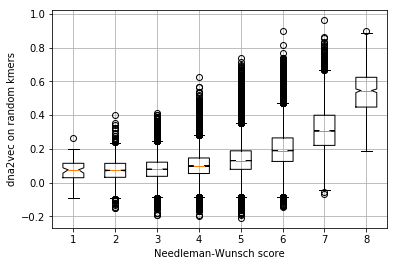

In [37]:
boxplot_of_distances(nw_rg_dists_kmr, c_rg_dists_kmr_d2v, "dna2vec on random kmers")